# Notes (deleted before hand in)

- Should the Grid Search be included in this code?

# Final notebook with all code gathered 
*Be aware that some of the codeblocks will return files to be stored - This will be clear before the block*

# Table of contents
0. Imports
1. Reading data
2. Find best train size
3. Making synthetic data
4. Making training data
5. Multinomial Naive Bayes
6. Convolutional Neural Network
7. Heatmaps

# 0. Imports

In [ ]:
import gzip
import json
import random
import time
from nltk import word_tokenize
from tqdm import tqdm
import contractions
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import os
import numpy as np
#import mlflow

# Imports for the synonym dictionary 
import requests
from bs4 import BeautifulSoup
from nltk.wsd import lesk

#wordnet imports
#importing NLTK corpus synonym dictionary, pos-tagging and checking the outputs
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
import random
from sklearn.pipeline import Pipeline

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


#Word2Vec imports
import gensim.models

#wordnet downloads
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

random.seed(42)


# CNN
import tensorflow as tf
from tensorflow.python.keras import layers, models
from tensorflow import keras

from tqdm import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Reading data

In [ ]:
#here
def reading_in(path):
    thing=[]
    for line in gzip.open(path):
        review_data = json.loads(line)
        subthing = dict()
        for key in review_data:
            subthing[key]= review_data[key]
        thing.append(subthing)
    return thing

In [ ]:
train = reading_in('data/classification/music_reviews_train.json.gz')
dev = reading_in('data/classification/music_reviews_dev.json.gz') # do not use!
#test = reading_in('../data/classification/music_reviews_test_masked.json.gz') #do not use!
train = shuffle(train, random_state=42)
dif = reading_in("data/difficult cases/all difficult cases.txt.gz")

In [ ]:
train_x = [i['reviewText'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]
train_y =  [i['sentiment'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]

dev_x = [i['reviewText'] if "reviewText" in i.keys() else "" for i in dev]
dev_y = [i['sentiment'] for i in dev]

Positive and negative not balanced

<BarContainer object of 2 artists>

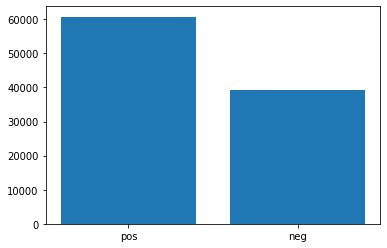

In [ ]:
pos_neg = [sum([i =="positive" for i in train_y]),sum([i != "positive" for i in train_y])]

plt.bar(x=["pos","neg"], height = pos_neg) 

Balancing the training data

In [ ]:
###split into pos and neg
train_x_pos = []
train_x_neg = []
train_y_pos = []
train_y_neg = []
for i in range(len(train_x)):
    if train_y[i] == "positive":
        train_x_pos.append(train_x[i])
        train_y_pos.append(train_y[i])
    else:
        train_x_neg.append(train_x[i])
        train_y_neg.append(train_y[i])
train_x_neg.extend(train_x_pos[0:len(train_x_neg)])
train_y_neg.extend(train_y_pos[0:len(train_y_neg)])
balanced_x_train_s = train_x_neg
balanced_y_train_s = train_y_neg

balanced_x_train, balanced_y_train = shuffle(balanced_x_train_s, balanced_y_train_s, random_state= 42)


### Reading in dificult cases

In [ ]:
cat_lab = {'emoji': 'emoji','emojii': 'emoji',

'code-switching': 'other languages','foreign language': 'other languages','different languages': 'other languages',

'typos': 'spelling and punctuation','spelling': 'spelling and punctuation','spelling error': 'spelling and punctuation',
'misspelling': 'spelling and punctuation',"{'typos'}": 'spelling and punctuation',"{'typos', 'punct'}": 'spelling and punctuation',
'typos, expand contractions, remove punctuation': 'spelling and punctuation',"{'punct'}": 'spelling and punctuation','typo': 'spelling and punctuation',

'irony': 'irony or sarcasm','irony/sarcasm': 'irony or sarcasm','sarcasm': 'irony or sarcasm','ironic': 'irony or sarcasm',

'negation': 'negation','negation (not + pos_adj)': 'negation','negation at the end': 'negation','short sentence with negation + postive adjective': 'negation',

'double negation': 'double negation','negated negatives': 'double negation',

'double meaning': 'confusing','confusing': 'confusing','hard to interpret': 'confusing','slang': 'confusing','vague': 'confusing','basic': 'confusing',

'strong words': 'exaggeration','exaggeration': 'exaggeration',

'replacement': 'vocabulary','synonym': 'vocabulary','ambigious words': 'vocabulary','rare words': 'vocabulary','infrequent word': 'vocabulary',

'sentiment change over time': 'sentiment change in text','sentiment over time': 'sentiment change in text','temporal': 'sentiment change in text','hopes vs reality': 'sentiment change in text',
'past and present thoughts': 'sentiment change in text','time change': 'sentiment change in text'

}

want = []
for i in dif:
    if i["category"].lower().strip() in cat_lab.keys():
        want.append(i)

dif_x = [i['reviewText'] for i in want if "reviewText" in i.keys() and "sentiment" in i.keys()]
dif_y =  [i['sentiment'] for i in want if "reviewText" in i.keys() and "sentiment" in i.keys()]
dif_cat_notthisone = [i['category'].lower().strip() for i in want if "reviewText" in i.keys() and "sentiment" in i.keys()]

# 1. Making synthetic data

Starting with initializing a simple tokenizer to split the words in the dataset such that the DAMs have words and not sentences to work at.

In [ ]:
def tokenize_corpus(corpus):
    return [word_tokenize(contractions.fix(s)) for s in corpus]

In [ ]:
train_x_split = tokenize_corpus(balanced_x_train)

## WebScrape Synonym replacement

In [ ]:
##Alternative to PyDictionary
##THIS IS COPIED FROM SLACK
# https://stackoverflow.com/questions/52910297/pydictionary-word-has-no-synonyms-in-the-api

def webscrape(term):
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})] # 'css-1gyuw4i eh475bn0' for less relevant synonyms


Function that replaces words with the synonym found by the webscrape above

In [ ]:
dont_replace = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will','I ', 'it ', 'she ', 'sie ', 'they ', 've ', 'xe ', 'you ', 'ze ', 'zie ','he',"you","we","mine","hers","his","yours","its","ours","theirs","your","our","oneself","oneselves","yourself","yourselves","himself","herself","himself","myself","themselves","itself","ourselves","ourself","us","them"] #Used to avoid changing function and pronouns words
def gen_synth_web(sentence,prob = 0.5):
    new_sen = []
    for word in sentence:
        if word in dont_replace:
            new_sen.append(word)
        else:
            threshold = random.random()
            if prob > threshold:
                #print(threshold) can remove later kept for debugging
                syn = webscrape(word)
                if len(syn) != 0:
                    #print("selected", word) can remove later kept for debugging
                    new_sen.append(random.choice(syn))
                else:new_sen.append(word)
            else:
                new_sen.append(word)
    return new_sen

Small example sentence

In [ ]:
print(train_x_split[3])
print('Synonym replaced:',gen_synth_web(train_x_split[3]) )

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
Synonym replaced: ['I', 'passion ', 'every ', 'sound', 'of', 'anything', 'George', 'Ezra', 'hum ', 'in', ';', 'remarkable', 'young', 'man', '.']


The below code block does data augmentation with the above WebScrape. Set run = True to run the code - Not recommended as it will take some time because of the limiter on the scrapes per second

In [ ]:
run = False
if run:
    for i in tqdm(train_x_split[:1000]):#running with 0:1000 dont uncomment as will mess up file 
        with open ("data/synthetic1.txt","a") as f:
            f.write(' '.join(gen_synth_web(i))+"\n")
            time.sleep(3)

## Wordnet



In [ ]:
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
wordnet_tag_map = {'NN': ['n'],'NNS': ['n'],'JJ': ['a'],'JJR': ['a'],'JJS': ['a'],'RB': ['r'],'RBR': ['r'],'RBS': ['r'], 'VB': ['v'], 'VBG': ['v'], 'VBD': ['v'], 'VBN': ['v'], 'VBP': ['v'], 'VBZ': ['v']} #Making pos-tags coincide
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_wordnet(sentence):
    sentence = nltk.pos_tag(sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if random.random()>0.5:
            if word[1] in relevant and word[0] not in aux_verbs: #Not changing functional words
                tag = wordnet_tag_map[word[1]]
                chosen = lesk(sentence, word[0], tag[0]) #from all synsets choose the most likely in a smart way, thanks to library!
                if chosen is None:
                    new_sentence.append(word[0]) #sometimes no synset is chosen so we just give the new sentence the original word
                else:
                    options = chosen.lemma_names()
                    if word[0] in options:
                        options.remove(word[0])
                    if len(options)>0:
                        chosen_w = random.choice(options)
                        if "_" in chosen_w:
                            for w in chosen_w.split("_"):
                                new_sentence.append(w)
                        else:
                            new_sentence.append(chosen_w)
                    else:
                        new_sentence.append(word[0])
            else:
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

Small example sentence

In [ ]:
print(train_x_split[3])
print('Synonym replaced:',change_wordnet(train_x_split[3]))

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
Synonym replaced: ['I', 'love', 'the', 'strait', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'immature', 'human', 'beings', '.']


The below code block does data augmentation with the above WordNet. Set run = True to run the code - Not recommended as it will take some time and write to a file

In [ ]:
run = False
if run:
    wn_x_train = [change_wordnet(i) for i in train_x_split]
    with open("data/synthetic/wordnet.csv",'w') as f:
        f.writelines('\t'.join(s) + '\n' for s in wn_x_train)

## Word2Vec
Loading the Google embeddings

In [ ]:
gooEmbs = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-50k.bin', binary=True)
print('loading finished')

loading finished


In [ ]:
# With a threshold and without the check of same word
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_word2vec(original_sentence, prob = 0.5, threshold = .6):
    sentence = nltk.pos_tag(original_sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if word[1] in relevant and word[0] not in aux_verbs:
            if random.random() > prob:
                try:
                    syno = gooEmbs.most_similar(word[0]) #taking the most similar word from word2vec
                    syno_pos = []
                    # method 1: 
                    for s in syno:
                        if s[1] > threshold:
                            syno_pos.append(s)
                        else: 
                            break # because all the words are sorted we know that if one word is under 60% all the others after are also
                    if syno_pos!=[]:
                        new_word = random.choice(syno_pos)[0]
                    else:  new_word = syno[0][0]
                    if "_" in new_word:
                        for w in chosen_w.split("_"):
                            new_sentence.append(w)
                    else: new_sentence.append(new_word)                    
                except:
                    new_sentence.append(word[0])
            else: 
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

Small example sentence

In [ ]:
print(train_x_split[3])
print('Synonym replaced:',change_word2vec(train_x_split[3]))

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
Synonym replaced: ['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']


The below code block does data augmentation with the above Word2Vec. Set run = True to run the code - Not recommended as it will take some time and write to a file

In [ ]:
run = False
if run:
    wn_x_train = [change_word2vec(i) for i in tqdm(train_x_split[:25000])]
    with open("data/synthetic/word2vec.csv",'w') as f:
        f.writelines('\t'.join(s) + '\n' for s in wn_x_train)


# 2. Best training size

In [ ]:
pipeline = Pipeline([
    ('CountVectorizer',CountVectorizer(ngram_range=(1, 2))),
    ('Tfidf',TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1, fit_prior=False))
])#best params given here

In [ ]:
def find_train_size():
    """
    90% train, 10% dev (test)
    """
    macro_f1 = []
    train_size = 1000
    
    while train_size <= len(train_x):
        
        temp_train_x = train_x[0:train_size]
        temp_train_y = train_y[0:train_size]

        pipeline.fit(temp_train_x, temp_train_y)
        pred_dev = pipeline.predict(dev_x)
                
        macro_f1.append((train_size, f1_score(pred_dev, dev_y, average='macro')))

        print(int(train_size))
        train_size += 1000
        
    return macro_f1

# 3. Making training data

The synthetic datasets are firstly read in from already made files

In [ ]:
def read_synth(path,deli):
    with open(path) as f:
        reader = csv.reader(f,delimiter = "\n")
        data = []
        for i in reader:
            i = contractions.fix(i[0].lower())
            data.append( re.sub(deli,' ',i))
           
    return data
paths = ["data/synthetic/webscrape.csv","data/synthetic/wordnet.csv","data/synthetic/word2vec.csv"]
deli = [" ","\t","\t"]

synthetic = dict()
names= ["web","net","vec"]
for x,i in enumerate(paths):
    synthetic[names[x]] = read_synth(i,deli[x])

Function that takes a sample of original data and adds the synthetic data from the specified DAM

In [ ]:
def add_together(synt_dataset_X, samples):
    OG_X = balanced_x_train[:samples]
    OG_y = balanced_y_train[:samples]
    train_X = OG_X + synt_dataset_X[:samples]
    train_y = OG_y + OG_y
    train_X, train_y = shuffle(train_X, train_y, random_state= 42)
    return train_X, train_y

Add all the wanted datasets together with the above function

In [ ]:
Scrape10_X, Scrape10_y = add_together(synthetic['web'], 10000)
Scrape5_X, Scrape5_y = add_together(synthetic['web'], 5000)
Scrape50_X, Scrape50_y = add_together(synthetic['web'], 500)
Scrape12_X, Scrape12_y = add_together(synthetic['web'], 1250)
Scrape2_X, Scrape2_y = add_together(synthetic['web'], 2500)
Scrape7_X, Scrape7_y = add_together(synthetic['web'], 7500)

Net10_X, Net10_y = add_together(synthetic['net'], 10000)
Net5_X, Net5_y = add_together(synthetic['net'], 5000)
Net7_X, Net7_y = add_together(synthetic['net'], 7500)
Net2_X, Net2_y = add_together(synthetic['net'], 2500)
Net12_X, Net12_y = add_together(synthetic['net'], 1250)
Net50_X, Net50_y = add_together(synthetic['net'], 500)

Vec10_X, Vec10_y =add_together(synthetic['vec'],10000)
Vec5_X, Vec5_y = add_together(synthetic['vec'], 5000)
Vec7_X, Vec7_y = add_together(synthetic['vec'], 7500)
Vec2_X, Vec2_y = add_together(synthetic['vec'], 2500)
Vec12_X, Vec12_y = add_together(synthetic['vec'], 1250)
Vec50_X, Vec50_y = add_together(synthetic['vec'], 500)

In [ ]:
# Training X, training y,  description
train_list = [
    [balanced_x_train[:500], balanced_y_train[:500] ,'original data 500'],
    [balanced_x_train[:1250], balanced_y_train[:1250] ,'original data 1250'],
    [balanced_x_train[:2500], balanced_y_train[:2500], 'original data 2500'], 
    [balanced_x_train[:5000], balanced_y_train[:5000], 'original data 5000'], 
    [balanced_x_train[:7500], balanced_y_train[:7500], 'original data 7500'], 
    [balanced_x_train[:10000], balanced_y_train[:10000],'original data 10000'],
    [balanced_x_train[:15000], balanced_y_train[:15000],'original data 15000'],
    [balanced_x_train[:20000], balanced_y_train[:20000],'original data 20000'],

    [Scrape50_X, Scrape50_y, 'WebScrape 500'],
    [Scrape12_X, Scrape12_y, 'WebScrape 1250'],
    [Scrape2_X, Scrape2_y, 'WebScrape 2500'],
    [Scrape5_X, Scrape5_y,'WebScrape 5000' ],
    [Scrape7_X, Scrape7_y, 'WebScrape 7500' ],
    [Scrape10_X, Scrape10_y , 'WebScrape 10000'],

    [Net50_X, Net50_y, 'WordNet 500'],
    [Net12_X, Net12_y , 'WordNet 1250'],
    [Net2_X, Net2_y, 'WordNet 2500'],
    [Net5_X, Net5_y , 'WordNet 5000'],    
    [Net7_X, Net7_y, 'WordNet 7500' ],
    [Net10_X, Net10_y, 'WordNet 10000'],    

    [Vec50_X, Vec50_y, 'Word2Vec 500' ],
    [Vec12_X, Vec12_y, 'Word2Vec 1250' ],
    [Vec2_X, Vec2_y, 'Word2Vec 2500' ],
    [Vec5_X, Vec5_y, 'Word2Vec 5000' ],
    [Vec7_X, Vec7_y, 'Word2Vec 7500' ], 
    [Vec10_X, Vec10_y, 'Word2Vec 10000' ]
]

# 4. Multinomial Naive Bayes

In [ ]:
MNB = Pipeline([
    ('CountVectorizer',TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', MultinomialNB(alpha=1, fit_prior=False))
])#best params given here

The below code block trains 26 different Multinomial Naive Bayes Model which will take around 5 minutes depending on computer efficiency

In [ ]:
run = False
if run:
    result = []
    for dset in tqdm(train_list):        
        #Get the data in the right format
        MNB.fit(dset[0], dset[1])



        #dataframes
        dev_pre = MNB.predict(dev_x)
        result.append([dset[2], f1_score(dev_y, dev_pre, average='macro')])    
        dev_pre = np.transpose(dev_pre, axes=None)
        devt_y = np.transpose(dev_y, axes=None)
        df = pd.DataFrame()
        df['True'] = dev_y
        df['Predicted'] = dev_pre

        df.to_csv(f"pics/NB/dev {dset[2]}.csv")
        #################

        dif_pre = MNB.predict(dif_x)
        dif_pre = np.transpose(dif_pre, axes=None)
        dif_temp_y = np.transpose(dif_y, axes=None)
        df = pd.DataFrame()
        df['True'] = dif_y
        df['Predicted'] = dif_pre

        df.to_csv(f"pics/NB/dif {dset[2]}.csv")

100%|██████████| 26/26 [01:23<00:00,  3.19s/it]


In [ ]:
for res in result:
    print(res[0], res[1])

original data 500 0.7402880944476093
original data 1250 0.7112798276215571
original data 2500 0.7825517519809355
original data 5000 0.8037027428492618
original data 7500 0.8207668490363977
original data 10000 0.8240790988377329
original data 15000 0.8266786450758599
original data 20000 0.8264702205545493
WebScrape 500 0.7347176574619341
WebScrape 1250 0.7108136513561859
WebScrape 2500 0.7855531068106438
WebScrape 5000 0.8042261449857933
WebScrape 7500 0.8216764167061094
WebScrape 10000 0.824383133756166
WordNet 500 0.755651684640027
WordNet 1250 0.7275491791196484
WordNet 2500 0.7924578958972812
WordNet 5000 0.8153414927985783
WordNet 7500 0.8279969658664779
WordNet 10000 0.8324999849249987
Word2Vec 500 0.7511556807764748
Word2Vec 1250 0.7238361161251504
Word2Vec 2500 0.7894602899208969
Word2Vec 5000 0.8130198808887621
Word2Vec 7500 0.8266947575164149
Word2Vec 10000 0.8301970046751624


# 5. Convolutional Neural Network
Functions used to make the CNN

In [ ]:
def pre_pros_y(data):
    encoder = LabelEncoder()
    encoder.fit(['negative', 'positive'])
    data = encoder.transform(data)
    return data


def ready_CNN(data_X, data_y, dev_x, dev_y, dif_x, dif_y):
    #ADD TOKENIZER TO THE DEVELEPMENT DATA

    vectorizer = TfidfVectorizer()
    tfid = vectorizer.fit(data_X)
    train_x = tfid.transform(data_X).toarray()
    train_x = np.reshape(train_x, (len(train_x), train_x.shape[1], 1))
    train_x = tf.convert_to_tensor(train_x)

    train_y = pre_pros_y(data_y)
    
    devt_x = tfid.transform(dev_x)
    devt_x = devt_x.toarray()
    devt_x = np.reshape(devt_x, (len(devt_x), devt_x.shape[1], 1))
    devt_x = tf.convert_to_tensor(devt_x)

    devt_y = pre_pros_y(dev_y)

    dif_x = tfid.transform(dif_x)
    dif_x = dif_x.toarray()
    dif_x = np.reshape(dif_x, (len(dif_x), dif_x.shape[1], 1))
    dif_x = tf.convert_to_tensor(dif_x)

    dif_y = pre_pros_y(dif_y)
    return train_x, train_y, devt_x, devt_y, dif_x, dif_y



In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

The below code block trains 26 different CNN Models which will take a couple of hours depending on computer efficiency - Therefore it is not recommended to set run = True

In [ ]:
run = False
if run:
    for i in tqdm(train_list):
        #with mlflow.start_run(run_name=f"CNN WE with {i[2]}"):
            
            tf.keras.backend.clear_session()
            tf.keras.backend.learning_phase()
            
            act = 'sigmoid'
            model = models.Sequential()
            model.add(layers.Conv1D(filters = 32, kernel_size = 10, strides = 5, padding = "same", activation='relu'))
            model.add(layers.AveragePooling1D(pool_size = 20, padding = "same", strides = 1))
            model.add(layers.Flatten())
            model.add(layers.Dense(256, activation=act))
            model.add(layers.Dense(512, activation=act))
            model.add(layers.Dense(256, activation=act))
            model.add(layers.Dense(1, activation=act))
            
            
            #Get the data in the right format
            train_x, train_y, devt_x, devt_y, dif_temp_x, dif_temp_y = ready_CNN(i[0], i[1],dev_x, dev_y, dif_x, dif_y)
            model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
            history = model.fit(train_x, train_y, epochs=10, batch_size = 500, callbacks=[callback], verbose=0) #change the numbers
            #metrics = model.evaluate(devt_x, devt_y, verbose=0) #change the number
            #mlflow.log_metric('binary_crossentropy', metrics[0])
            #mlflow.log_metric('accuracy', metrics[1])
            #mlflow.log_param('Actual epochs',len(history.history['loss']) )
            #mlflow.log_param('NN size', '[256, 512, 256, 1, epoch = 10, betch = 500]')
            #mlflow.log_param('activation', act)
            model.save(f'models/{i[2]}')
            
            #dataframes
            dev_pre = model.predict(devt_x)
            devt_y = np.reshape(devt_y, [len(devt_y),1])
            #print(dev_pre.shape)
            #dev_pre = dev_pre[:, 0, :]
            
            devt_y = np.transpose(devt_y, axes=None)
            dev_pre = np.transpose(dev_pre, axes=None)
            devt_y = devt_y.tolist()
            dev_pre = dev_pre.tolist()
            
            df = pd.DataFrame(list(zip(devt_y[0], dev_pre[0])),
                columns =['True', 'Predicted'])
        
            df.to_csv(f"pics/CNN/dev {i[2]}.csv")
            #################
            dif_pre = model.predict(dif_temp_x)
            dif_temp_y = np.reshape(dif_temp_y, [len(dif_temp_y),1])
            #dif_pre = dif_pre[:, 0, :]
            
            dif_temp_y = np.transpose(dif_temp_y, axes=None)
            dif_pre = np.transpose(dif_pre, axes=None)
            dif_temp_y = dif_temp_y.tolist()
            dif_pre = dif_pre.tolist()
            
            df = pd.DataFrame(list(zip(dif_temp_y[0], dif_pre[0], dif_cat_notthisone)),
                columns =['True', 'Predicted', 'Cat'])
        
            df.to_csv(f"pics/CNN/dif {i[2]}.csv")

  4%|▍         | 1/26 [00:23<09:58, 23.94s/it]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

# 6. Heatmaps

## Heatmaps - Naive Bayes

In [ ]:
def pre(df):
    end_df = []

    for i in df:
        print(i.columns)
        pre_pro = []

        pre = i['Predicted'].tolist()
        for p in pre:
            if p == 'positive':
                pre_pro.append(1)
            else:
                pre_pro.append(0)
        
        true_pro = []
        true = i['True'].tolist()
        for p in true:
            if p == 'positive':
                true_pro.append(1)
            else:
                true_pro.append(0)

        i['Predicted'] = pre_pro
        i['True'] = true_pro
        end_df.append(i)
    return end_df

In [ ]:
dev = [ 'dev WordNet 500.csv', 'dev Word2Vec 500.csv','dev WebScrape 500.csv', 'dev original data 500.csv',\
    'dev WordNet 1250.csv', 'dev Word2Vec 1250.csv',  'dev WebScrape 1250.csv',  'dev original data 1250.csv',\
 'dev WordNet 2500.csv',  'dev Word2Vec 2500.csv', 'dev WebScrape 2500.csv',  'dev original data 2500.csv', \
 'dev WordNet 5000.csv',  'dev Word2Vec 5000.csv',  'dev WebScrape 5000.csv',  'dev original data 5000.csv',\
 'dev WordNet 7500.csv',  'dev Word2Vec 7500.csv', 'dev WebScrape 7500.csv', 'dev original data 7500.csv',\
 'dev WordNet 10000.csv', 'dev Word2Vec 10000.csv', 'dev WebScrape 10000.csv', 'dev original data 10000.csv'\
]

dif =  [ 'dif WordNet 500.csv', 'dif Word2Vec 500.csv','dif WebScrape 500.csv', 'dif original data 500.csv',\
 'dif WordNet 1250.csv', 'dif Word2Vec 1250.csv',  'dif WebScrape 1250.csv',  'dif original data 1250.csv',\
 'dif WordNet 2500.csv',  'dif Word2Vec 2500.csv', 'dif WebScrape 2500.csv',  'dif original data 2500.csv', \
 'dif WordNet 5000.csv',  'dif Word2Vec 5000.csv',  'dif WebScrape 5000.csv',  'dif original data 5000.csv',\
 'dif WordNet 7500.csv',  'dif Word2Vec 7500.csv', 'dif WebScrape 7500.csv', 'dif original data 7500.csv',\
 'dif WordNet 10000.csv', 'dif Word2Vec 10000.csv', 'dif WebScrape 10000.csv', 'dif original data 10000.csv'\
]

In [ ]:
dif_p = [pd.read_csv('pics/NB/'+i) for i in dif]
dev_p = [pd.read_csv('pics/NB/'+i) for i in dev]

In [ ]:
dif_p = pre(dif_p)
dev_p = pre(dev_p)

Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object')
Index(['Unnamed: 0', 'True', 'Predicted'], dtype='object

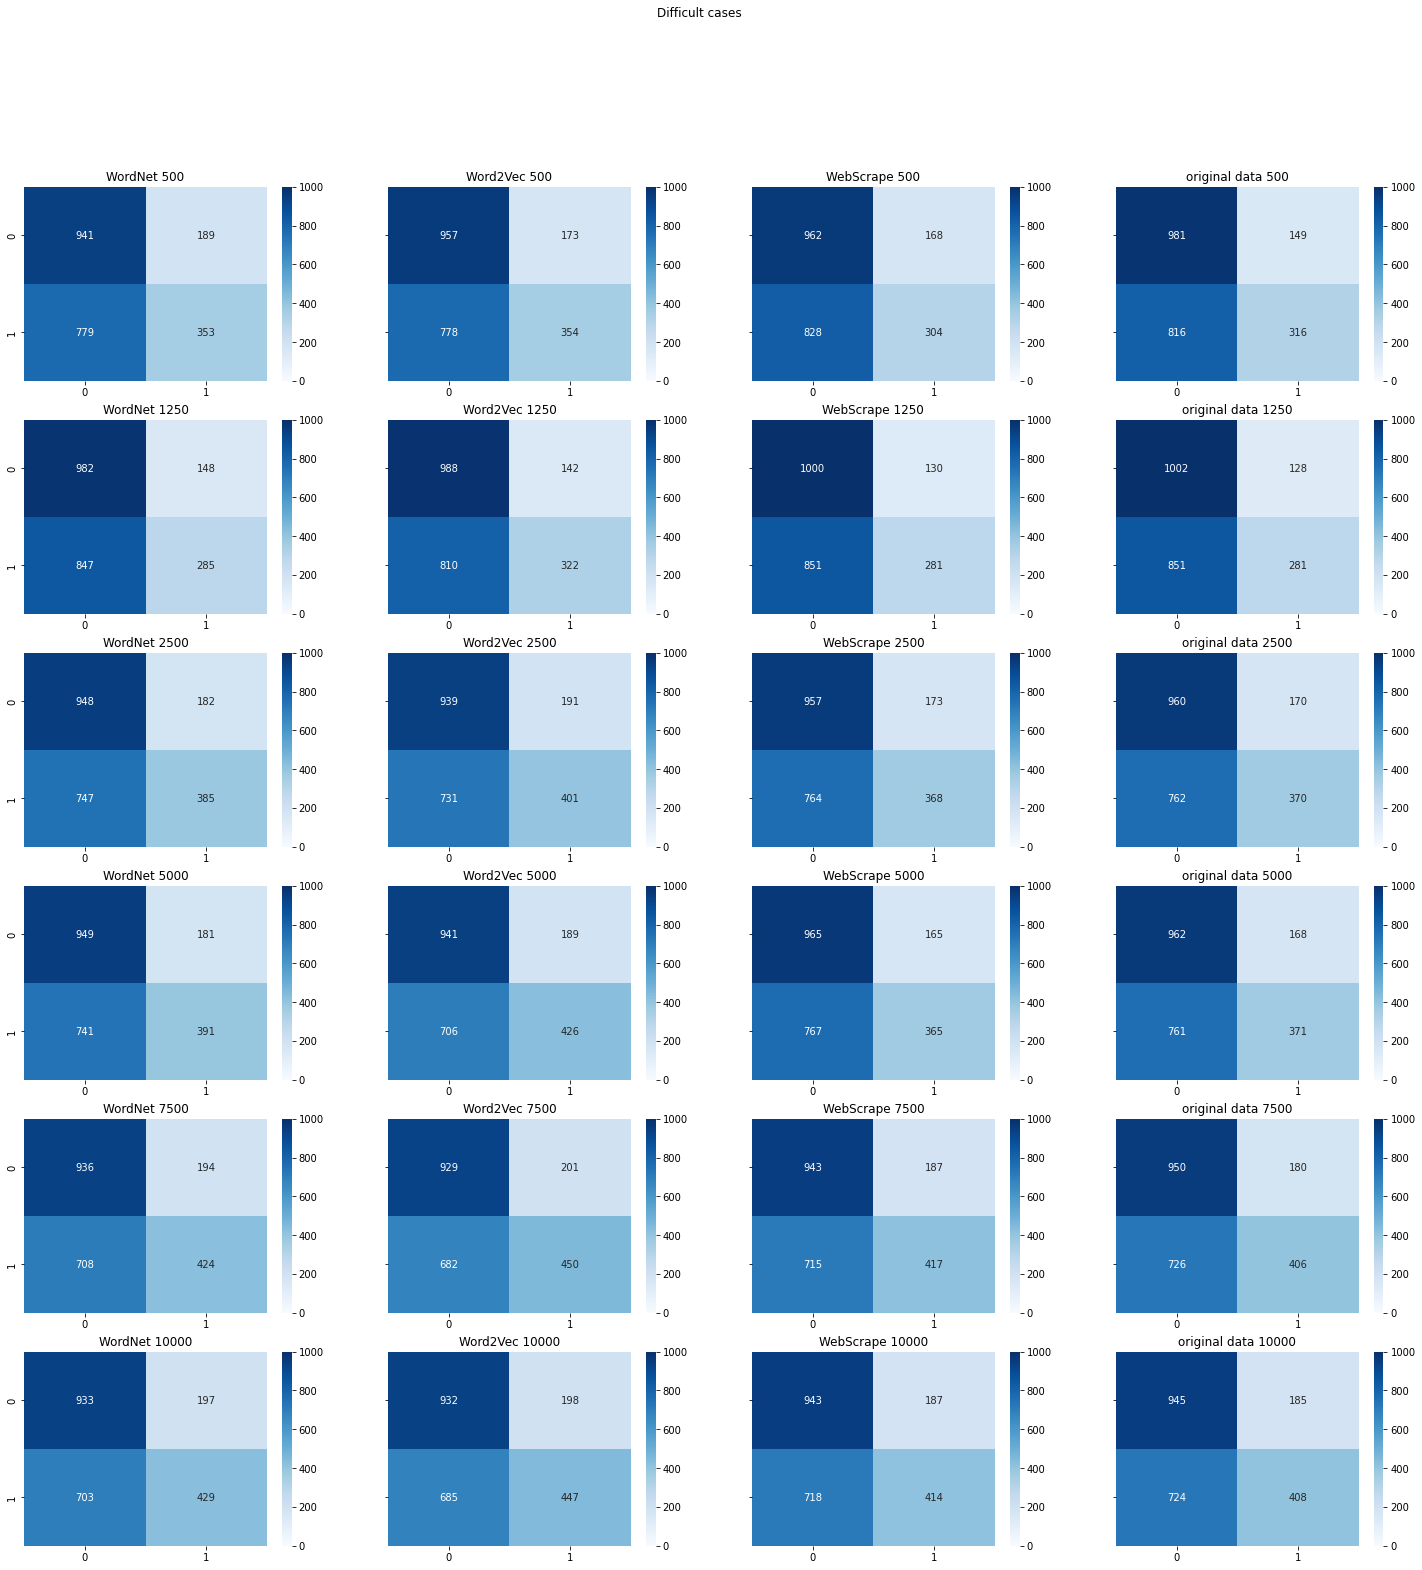

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(25, 25), sharey=True)
fig.suptitle('Difficult cases')
cmap = sns.color_palette("Blues", as_cmap=True)


sns.heatmap(confusion_matrix(dif_p[0]['True'], dif_p[0]['Predicted']), cmap = cmap ,ax = axes[0,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[0][4:-4])
sns.heatmap(confusion_matrix(dif_p[1]['True'], dif_p[1]['Predicted']), cmap = cmap ,ax = axes[0,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[1][4:-4])
sns.heatmap(confusion_matrix(dif_p[2]['True'], dif_p[2]['Predicted']), cmap = cmap ,ax = axes[0,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[2][4:-4])
sns.heatmap(confusion_matrix(dif_p[3]['True'], dif_p[3]['Predicted']), cmap = cmap ,ax = axes[0,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[3][4:-4])

sns.heatmap(confusion_matrix(dif_p[4]['True'], dif_p[4]['Predicted']), cmap = cmap ,ax = axes[1,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[4][4:-4])
sns.heatmap(confusion_matrix(dif_p[5]['True'], dif_p[5]['Predicted']), cmap = cmap ,ax = axes[1,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[5][4:-4])
sns.heatmap(confusion_matrix(dif_p[6]['True'], dif_p[6]['Predicted']), cmap = cmap ,ax = axes[1,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[6][4:-4])
sns.heatmap(confusion_matrix(dif_p[7]['True'], dif_p[7]['Predicted']), cmap = cmap ,ax = axes[1,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[7][4:-4])

sns.heatmap(confusion_matrix(dif_p[8]['True'], dif_p[8]['Predicted']), cmap = cmap ,ax = axes[2,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[8][4:-4])
sns.heatmap(confusion_matrix(dif_p[9]['True'], dif_p[9]['Predicted']), cmap = cmap ,ax = axes[2,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[9][4:-4])
sns.heatmap(confusion_matrix(dif_p[10]['True'], dif_p[10]['Predicted']),cmap = cmap , ax = axes[2,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[10][4:-4])
sns.heatmap(confusion_matrix(dif_p[11]['True'], dif_p[11]['Predicted']),cmap = cmap , ax = axes[2,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[11][4:-4])

sns.heatmap(confusion_matrix(dif_p[12]['True'], dif_p[12]['Predicted']),cmap = cmap , ax = axes[3,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[12][4:-4])
sns.heatmap(confusion_matrix(dif_p[13]['True'], dif_p[13]['Predicted']),cmap = cmap , ax = axes[3,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[13][4:-4])
sns.heatmap(confusion_matrix(dif_p[14]['True'], dif_p[14]['Predicted']),cmap = cmap , ax = axes[3,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[14][4:-4])
sns.heatmap(confusion_matrix(dif_p[15]['True'], dif_p[15]['Predicted']),cmap = cmap , ax = axes[3,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[15][4:-4])

sns.heatmap(confusion_matrix(dif_p[16]['True'], dif_p[16]['Predicted']), cmap = cmap ,ax = axes[4,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[16][4:-4])
sns.heatmap(confusion_matrix(dif_p[17]['True'], dif_p[17]['Predicted']), cmap = cmap ,ax = axes[4,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[17][4:-4])
sns.heatmap(confusion_matrix(dif_p[18]['True'], dif_p[18]['Predicted']), cmap = cmap ,ax = axes[4,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[18][4:-4])
sns.heatmap(confusion_matrix(dif_p[19]['True'], dif_p[19]['Predicted']), cmap = cmap ,ax = axes[4,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[19][4:-4])

sns.heatmap(confusion_matrix(dif_p[20]['True'], dif_p[20]['Predicted']),cmap = cmap , ax = axes[5,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[20][4:-4])
sns.heatmap(confusion_matrix(dif_p[21]['True'], dif_p[21]['Predicted']),cmap = cmap , ax = axes[5,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[21][4:-4])
sns.heatmap(confusion_matrix(dif_p[22]['True'], dif_p[22]['Predicted']),cmap = cmap , ax = axes[5,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[22][4:-4])
sns.heatmap(confusion_matrix(dif_p[23]['True'], dif_p[23]['Predicted']),cmap = cmap , ax = axes[5,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[23][4:-4])

save = False
if save:
    plt.savefig('pics/maps/NB/Difficult cases NB')

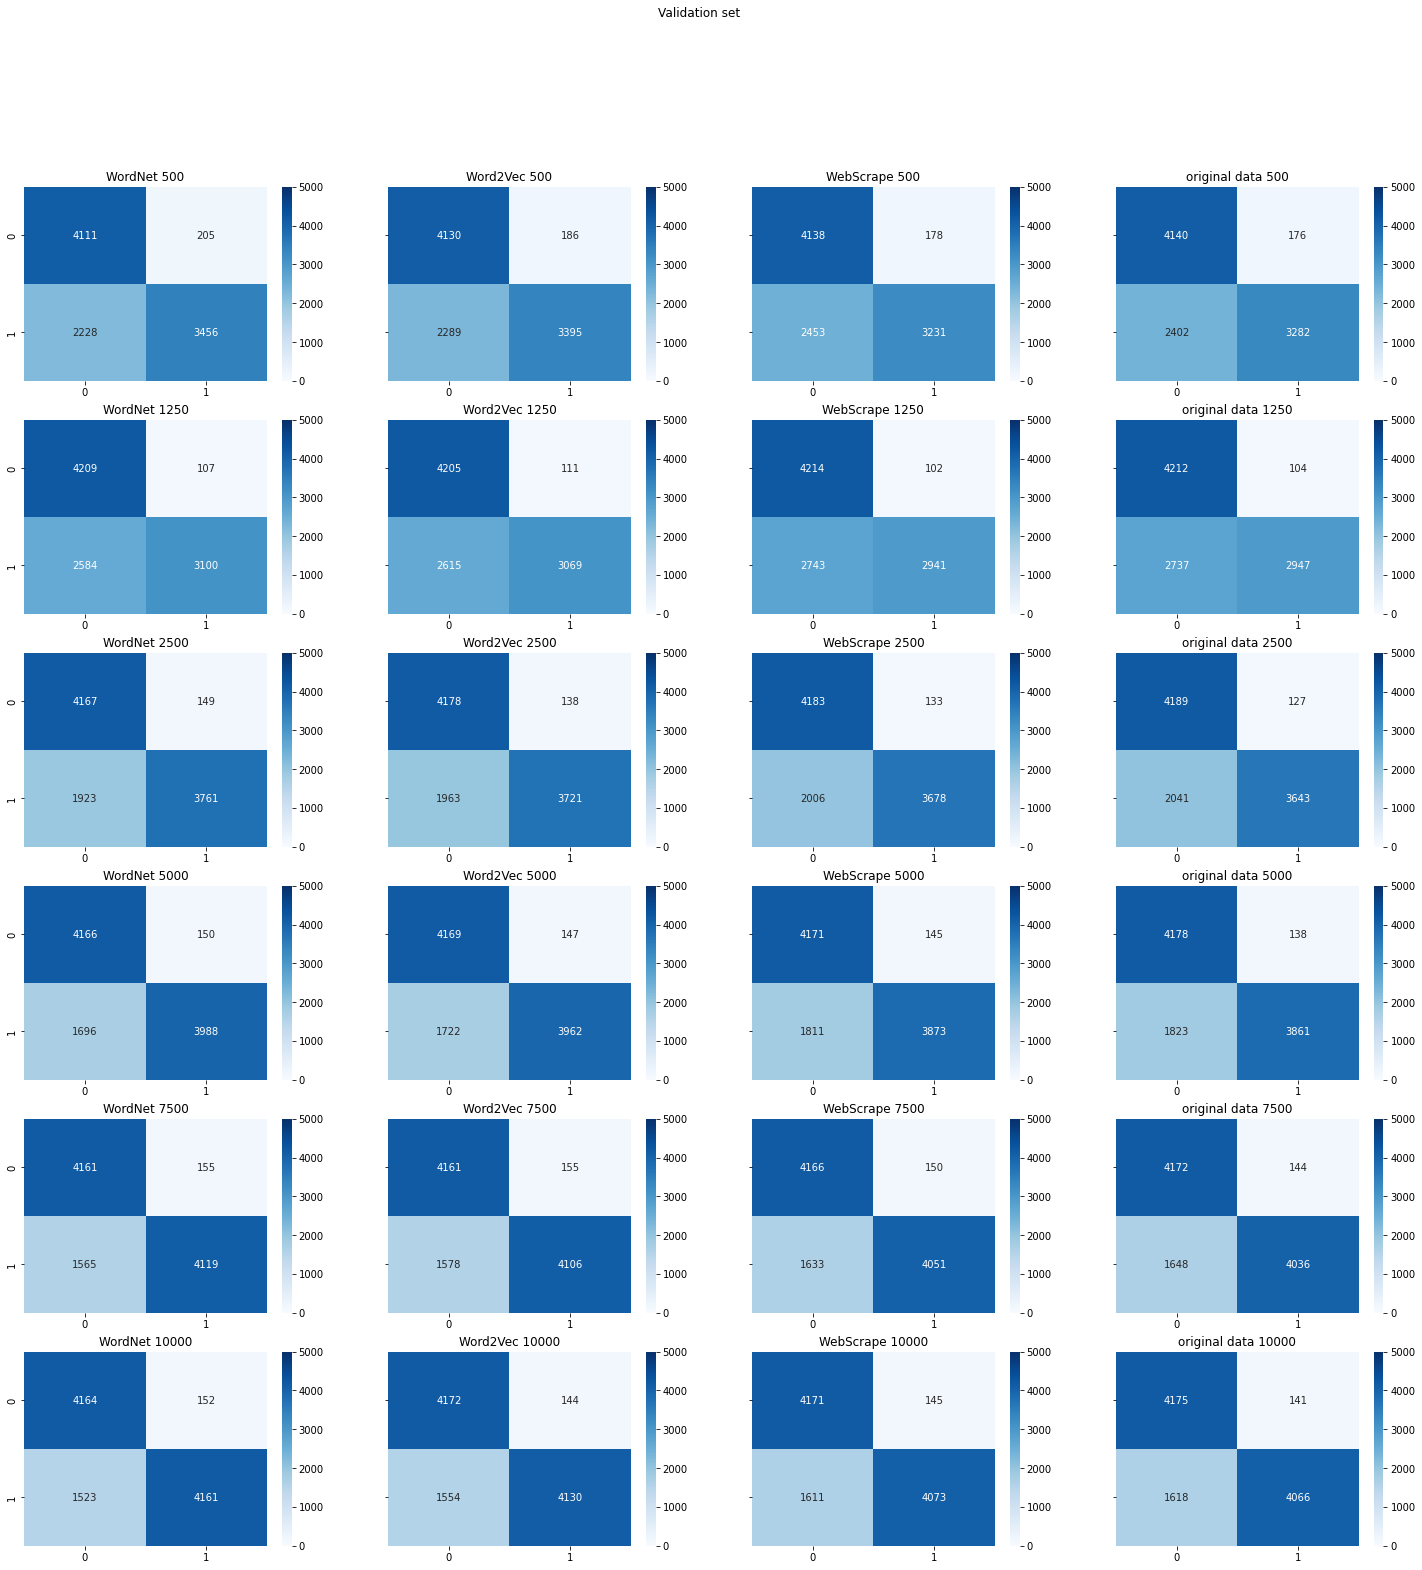

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(25, 25), sharey=True)
fig.suptitle('Validation set')

sns.heatmap(confusion_matrix(dev_p[0]['True'], dev_p[0]['Predicted']), cmap = cmap ,ax = axes[0,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[0][4:-4])
sns.heatmap(confusion_matrix(dev_p[1]['True'], dev_p[1]['Predicted']), cmap = cmap ,ax = axes[0,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[1][4:-4])
sns.heatmap(confusion_matrix(dev_p[2]['True'], dev_p[2]['Predicted']), cmap = cmap ,ax = axes[0,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[2][4:-4])
sns.heatmap(confusion_matrix(dev_p[3]['True'], dev_p[3]['Predicted']), cmap = cmap ,ax = axes[0,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[3][4:-4])

sns.heatmap(confusion_matrix(dev_p[4]['True'], dev_p[4]['Predicted']), cmap = cmap ,ax = axes[1,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[4][4:-4])
sns.heatmap(confusion_matrix(dev_p[5]['True'], dev_p[5]['Predicted']), cmap = cmap ,ax = axes[1,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[5][4:-4])
sns.heatmap(confusion_matrix(dev_p[6]['True'], dev_p[6]['Predicted']), cmap = cmap ,ax = axes[1,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[6][4:-4])
sns.heatmap(confusion_matrix(dev_p[7]['True'], dev_p[7]['Predicted']), cmap = cmap ,ax = axes[1,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[7][4:-4])

sns.heatmap(confusion_matrix(dev_p[8]['True'], dev_p[8]['Predicted']), cmap = cmap ,ax = axes[2,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[8][4:-4])
sns.heatmap(confusion_matrix(dev_p[9]['True'], dev_p[9]['Predicted']), cmap = cmap ,ax = axes[2,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[9][4:-4])
sns.heatmap(confusion_matrix(dev_p[10]['True'], dev_p[10]['Predicted']),cmap = cmap , ax = axes[2,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[10][4:-4])
sns.heatmap(confusion_matrix(dev_p[11]['True'], dev_p[11]['Predicted']),cmap = cmap , ax = axes[2,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[11][4:-4])

sns.heatmap(confusion_matrix(dev_p[12]['True'], dev_p[12]['Predicted']),cmap = cmap , ax = axes[3,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[12][4:-4])
sns.heatmap(confusion_matrix(dev_p[13]['True'], dev_p[13]['Predicted']),cmap = cmap , ax = axes[3,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[13][4:-4])
sns.heatmap(confusion_matrix(dev_p[14]['True'], dev_p[14]['Predicted']),cmap = cmap , ax = axes[3,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[14][4:-4])
sns.heatmap(confusion_matrix(dev_p[15]['True'], dev_p[15]['Predicted']),cmap = cmap , ax = axes[3,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[15][4:-4])

sns.heatmap(confusion_matrix(dev_p[16]['True'], dev_p[16]['Predicted']), cmap = cmap ,ax = axes[4,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[16][4:-4])
sns.heatmap(confusion_matrix(dev_p[17]['True'], dev_p[17]['Predicted']), cmap = cmap ,ax = axes[4,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[17][4:-4])
sns.heatmap(confusion_matrix(dev_p[18]['True'], dev_p[18]['Predicted']), cmap = cmap ,ax = axes[4,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[18][4:-4])
sns.heatmap(confusion_matrix(dev_p[19]['True'], dev_p[19]['Predicted']), cmap = cmap ,ax = axes[4,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[19][4:-4])

sns.heatmap(confusion_matrix(dev_p[20]['True'], dev_p[20]['Predicted']),cmap = cmap , ax = axes[5,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[20][4:-4])
sns.heatmap(confusion_matrix(dev_p[21]['True'], dev_p[21]['Predicted']),cmap = cmap , ax = axes[5,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[21][4:-4])
sns.heatmap(confusion_matrix(dev_p[22]['True'], dev_p[22]['Predicted']),cmap = cmap , ax = axes[5,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[22][4:-4])
sns.heatmap(confusion_matrix(dev_p[23]['True'], dev_p[23]['Predicted']),cmap = cmap , ax = axes[5,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[23][4:-4])

save = False
if save:
    plt.savefig('pics/maps/NB/Validation cases NB')

## Heatmaps - Convolutional Neural Network

In [ ]:
def pre(df):
    end_df = []
    for i in df:
        pre_pro = []
        pre = i['Predicted'].tolist()
        for p in pre:
            if p > 0.5:
                pre_pro.append(1)
            else:
                pre_pro.append(0)
        i['Predicted'] = pre_pro
        end_df.append(i)
    return end_df

In [ ]:
dev = [ 'dev WordNet 500.csv', 'dev Word2Vec 500.csv','dev WebScrape 500.csv', 'dev original data 500.csv',\
    'dev WordNet 1250.csv', 'dev Word2Vec 1250.csv',  'dev WebScrape 1250.csv',  'dev original data 1250.csv',\
 'dev WordNet 2500.csv',  'dev Word2Vec 2500.csv', 'dev WebScrape 2500.csv',  'dev original data 2500.csv', \
 'dev WordNet 5000.csv',  'dev Word2Vec 5000.csv',  'dev WebScrape 5000.csv',  'dev original data 5000.csv',\
 'dev WordNet 7500.csv',  'dev Word2Vec 7500.csv', 'dev WebScrape 7500.csv', 'dev original data 7500.csv',\
 'dev WordNet 10000.csv', 'dev Word2Vec 10000.csv', 'dev WebScrape 10000.csv', 'dev original data 10000.csv'\
]

dif =  [ 'dif WordNet 500.csv', 'dif Word2Vec 500.csv','dif WebScrape 500.csv', 'dif original data 500.csv',\
 'dif WordNet 1250.csv', 'dif Word2Vec 1250.csv',  'dif WebScrape 1250.csv',  'dif original data 1250.csv',\
 'dif WordNet 2500.csv',  'dif Word2Vec 2500.csv', 'dif WebScrape 2500.csv',  'dif original data 2500.csv', \
 'dif WordNet 5000.csv',  'dif Word2Vec 5000.csv',  'dif WebScrape 5000.csv',  'dif original data 5000.csv',\
 'dif WordNet 7500.csv',  'dif Word2Vec 7500.csv', 'dif WebScrape 7500.csv', 'dif original data 7500.csv',\
 'dif WordNet 10000.csv', 'dif Word2Vec 10000.csv', 'dif WebScrape 10000.csv', 'dif original data 10000.csv'\
]

In [ ]:
dif_p = [pd.read_csv('pics/CNN'+i) for i in dif]
dev_p = [pd.read_csv('pics/CNN'+i) for i in dev]

In [ ]:
dif_p = pre(dif_p)
dev_p = pre(dev_p)

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(25, 25), sharey=True)
cmap = sns.color_palette("Blues", as_cmap=True)


sns.heatmap(confusion_matrix(dif_p[0]['True'], dif_p[0]['Predicted']), cmap = cmap ,ax = axes[0,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[0][4:-4])
sns.heatmap(confusion_matrix(dif_p[1]['True'], dif_p[1]['Predicted']), cmap = cmap ,ax = axes[0,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[1][4:-4])
sns.heatmap(confusion_matrix(dif_p[2]['True'], dif_p[2]['Predicted']), cmap = cmap ,ax = axes[0,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[2][4:-4])
sns.heatmap(confusion_matrix(dif_p[3]['True'], dif_p[3]['Predicted']), cmap = cmap ,ax = axes[0,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[3][4:-4])

sns.heatmap(confusion_matrix(dif_p[4]['True'], dif_p[4]['Predicted']), cmap = cmap ,ax = axes[1,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[4][4:-4])
sns.heatmap(confusion_matrix(dif_p[5]['True'], dif_p[5]['Predicted']), cmap = cmap ,ax = axes[1,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[5][4:-4])
sns.heatmap(confusion_matrix(dif_p[6]['True'], dif_p[6]['Predicted']), cmap = cmap ,ax = axes[1,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[6][4:-4])
sns.heatmap(confusion_matrix(dif_p[7]['True'], dif_p[7]['Predicted']), cmap = cmap ,ax = axes[1,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[7][4:-4])

sns.heatmap(confusion_matrix(dif_p[8]['True'], dif_p[8]['Predicted']), cmap = cmap ,ax = axes[2,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[8][4:-4])
sns.heatmap(confusion_matrix(dif_p[9]['True'], dif_p[9]['Predicted']), cmap = cmap ,ax = axes[2,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[9][4:-4])
sns.heatmap(confusion_matrix(dif_p[10]['True'], dif_p[10]['Predicted']),cmap = cmap , ax = axes[2,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[10][4:-4])
sns.heatmap(confusion_matrix(dif_p[11]['True'], dif_p[11]['Predicted']),cmap = cmap , ax = axes[2,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[11][4:-4])

sns.heatmap(confusion_matrix(dif_p[12]['True'], dif_p[12]['Predicted']),cmap = cmap , ax = axes[3,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[12][4:-4])
sns.heatmap(confusion_matrix(dif_p[13]['True'], dif_p[13]['Predicted']),cmap = cmap , ax = axes[3,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[13][4:-4])
sns.heatmap(confusion_matrix(dif_p[14]['True'], dif_p[14]['Predicted']),cmap = cmap , ax = axes[3,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[14][4:-4])
sns.heatmap(confusion_matrix(dif_p[15]['True'], dif_p[15]['Predicted']),cmap = cmap , ax = axes[3,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[15][4:-4])

sns.heatmap(confusion_matrix(dif_p[16]['True'], dif_p[16]['Predicted']), cmap = cmap ,ax = axes[4,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[16][4:-4])
sns.heatmap(confusion_matrix(dif_p[17]['True'], dif_p[17]['Predicted']), cmap = cmap ,ax = axes[4,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[17][4:-4])
sns.heatmap(confusion_matrix(dif_p[18]['True'], dif_p[18]['Predicted']), cmap = cmap ,ax = axes[4,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[18][4:-4])
sns.heatmap(confusion_matrix(dif_p[19]['True'], dif_p[19]['Predicted']), cmap = cmap ,ax = axes[4,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[19][4:-4])

sns.heatmap(confusion_matrix(dif_p[20]['True'], dif_p[20]['Predicted']),cmap = cmap , ax = axes[5,0], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[20][4:-4])
sns.heatmap(confusion_matrix(dif_p[21]['True'], dif_p[21]['Predicted']),cmap = cmap , ax = axes[5,1], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[21][4:-4])
sns.heatmap(confusion_matrix(dif_p[22]['True'], dif_p[22]['Predicted']),cmap = cmap , ax = axes[5,2], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[22][4:-4])
sns.heatmap(confusion_matrix(dif_p[23]['True'], dif_p[23]['Predicted']),cmap = cmap , ax = axes[5,3], annot=True, fmt="d", vmin = 0, vmax = 1000).set(title= dif[23][4:-4])

save = False
if save:
    plt.savefig('pics/maps/CNN/Difficult cases CNN')

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(25, 25), sharey=True)

sns.heatmap(confusion_matrix(dev_p[0]['True'], dev_p[0]['Predicted']), cmap = cmap ,ax = axes[0,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[0][4:-4])
sns.heatmap(confusion_matrix(dev_p[1]['True'], dev_p[1]['Predicted']), cmap = cmap ,ax = axes[0,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[1][4:-4])
sns.heatmap(confusion_matrix(dev_p[2]['True'], dev_p[2]['Predicted']), cmap = cmap ,ax = axes[0,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[2][4:-4])
sns.heatmap(confusion_matrix(dev_p[3]['True'], dev_p[3]['Predicted']), cmap = cmap ,ax = axes[0,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[3][4:-4])

sns.heatmap(confusion_matrix(dev_p[4]['True'], dev_p[4]['Predicted']), cmap = cmap ,ax = axes[1,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[4][4:-4])
sns.heatmap(confusion_matrix(dev_p[5]['True'], dev_p[5]['Predicted']), cmap = cmap ,ax = axes[1,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[5][4:-4])
sns.heatmap(confusion_matrix(dev_p[6]['True'], dev_p[6]['Predicted']), cmap = cmap ,ax = axes[1,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[6][4:-4])
sns.heatmap(confusion_matrix(dev_p[7]['True'], dev_p[7]['Predicted']), cmap = cmap ,ax = axes[1,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[7][4:-4])

sns.heatmap(confusion_matrix(dev_p[8]['True'], dev_p[8]['Predicted']), cmap = cmap ,ax = axes[2,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[8][4:-4])
sns.heatmap(confusion_matrix(dev_p[9]['True'], dev_p[9]['Predicted']), cmap = cmap ,ax = axes[2,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[9][4:-4])
sns.heatmap(confusion_matrix(dev_p[10]['True'], dev_p[10]['Predicted']),cmap = cmap , ax = axes[2,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[10][4:-4])
sns.heatmap(confusion_matrix(dev_p[11]['True'], dev_p[11]['Predicted']),cmap = cmap , ax = axes[2,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[11][4:-4])

sns.heatmap(confusion_matrix(dev_p[12]['True'], dev_p[12]['Predicted']),cmap = cmap , ax = axes[3,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[12][4:-4])
sns.heatmap(confusion_matrix(dev_p[13]['True'], dev_p[13]['Predicted']),cmap = cmap , ax = axes[3,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[13][4:-4])
sns.heatmap(confusion_matrix(dev_p[14]['True'], dev_p[14]['Predicted']),cmap = cmap , ax = axes[3,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[14][4:-4])
sns.heatmap(confusion_matrix(dev_p[15]['True'], dev_p[15]['Predicted']),cmap = cmap , ax = axes[3,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[15][4:-4])

sns.heatmap(confusion_matrix(dev_p[16]['True'], dev_p[16]['Predicted']), cmap = cmap ,ax = axes[4,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[16][4:-4])
sns.heatmap(confusion_matrix(dev_p[17]['True'], dev_p[17]['Predicted']), cmap = cmap ,ax = axes[4,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[17][4:-4])
sns.heatmap(confusion_matrix(dev_p[18]['True'], dev_p[18]['Predicted']), cmap = cmap ,ax = axes[4,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[18][4:-4])
sns.heatmap(confusion_matrix(dev_p[19]['True'], dev_p[19]['Predicted']), cmap = cmap ,ax = axes[4,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[19][4:-4])

sns.heatmap(confusion_matrix(dev_p[20]['True'], dev_p[20]['Predicted']),cmap = cmap , ax = axes[5,0], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[20][4:-4])
sns.heatmap(confusion_matrix(dev_p[21]['True'], dev_p[21]['Predicted']),cmap = cmap , ax = axes[5,1], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[21][4:-4])
sns.heatmap(confusion_matrix(dev_p[22]['True'], dev_p[22]['Predicted']),cmap = cmap , ax = axes[5,2], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[22][4:-4])
sns.heatmap(confusion_matrix(dev_p[23]['True'], dev_p[23]['Predicted']),cmap = cmap , ax = axes[5,3], annot=True, fmt="d", vmin = 0, vmax = 5000).set(title= dev[23][4:-4])

save = False
if save:
    plt.savefig('pics/maps/CNN/Validation cases CNN')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6518c231-62d3-4934-9c6d-1fd21f03a8fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>